<a href="https://colab.research.google.com/github/gmfv/Prediccion_Temperatura_IA/blob/main/Genetic2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap

     |████████████████████████████████| 163kB 6.6MB/s 


In [2]:
!pip install bitstring

     |████████████████████████████████| 204kB 6.9MB/s 
  Created wheel for bitstring: filename=bitstring-3.1.7-cp37-none-any.whl size=37949 sha256=ccb2940a2106efaedf97103bcc7eb902dfa63e84caca6a2175a58d49ea82525a
  Stored in directory: /root/.cache/pip/wheels/b8/27/f0/8373e26b7de57db03dc18aaaebdd8c26a99da882416f762979
Successfully built bitstring


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import LSTM, Input, Dense
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

np.random.seed(1120)

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/gmfv/Prediccion_Temperatura_IA/main/temperatura.csv')
data = data[52464:]
data["Temperatura Asuncion"]

52464    22.9
52465    22.1
52466    22.3
52467    22.5
52468    22.7
         ... 
78691    34.6
78692    35.1
78693    34.6
78694    34.6
78695    31.2
Name: Temperatura Asuncion, Length: 26232, dtype: float64

In [5]:
data = np.reshape(np.array(data['Temperatura Asuncion']),(len(data['Temperatura Asuncion']),1))

# Use first 21000 points as training/validation and rest of the 5232 points as test set.
train_data = data[0:21000]
test_data = data[21000:]

In [6]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    num_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_units)
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if window_size == 0 or num_units == 0:
        return 100, 
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data,window_size)
    X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    inputs = Input(shape=(window_size,1))
    x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    predictions = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=5, batch_size=10,shuffle=True)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

In [7]:
population_size = 4
num_generations = 4
gene_length = 10

creator.create('FitnessMax', base.Fitness, weights = (1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
#population = lista de individuos; cxpb probabilidad de aparear dos individuos; mutpb probabilidad de mutar un individuo;  ngen numero de generaciones; 
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, 
ngen = num_generations, verbose = False)


Window Size:  36 , Num of Units:  2
Epoch 1/5
1677/1677 [==============================] - 32s 8ms/step - loss: 498.7895
Epoch 2/5
1677/1677 [==============================] - 14s 8ms/step - loss: 301.5050
Epoch 3/5
1677/1677 [==============================] - 14s 8ms/step - loss: 178.4548
Epoch 4/5
1677/1677 [==============================] - 14s 8ms/step - loss: 99.3658
Epoch 5/5
1677/1677 [==============================] - 14s 8ms/step - loss: 50.6235
Validation RMSE:  5.2782477460062 


Window Size:  56 , Num of Units:  8
Epoch 1/5
1676/1676 [==============================] - 35s 19ms/step - loss: 395.0560
Epoch 2/5
1676/1676 [==============================] - 32s 19ms/step - loss: 62.2900
Epoch 3/5
1676/1676 [==============================] - 32s 19ms/step - loss: 12.3243
Epoch 4/5
1676/1676 [==============================] - 32s 19ms/step - loss: 3.9647
Epoch 5/5
1676/1676 [==============================] - 33s 20ms/step - loss: 2.1185
Validation RMSE:  1.2423201974540299 


Win

In [8]:
# Print top N solutions - (1st only, for now)
best_individuals = tools.selBest(population,k = 1)
best_window_size = None
best_num_units = None

for bi in best_individuals:
    window_size_bits = BitArray(bi[0:6])
    num_units_bits = BitArray(bi[6:]) 
    best_window_size = window_size_bits.uint
    best_num_units = num_units_bits.uint
    print('\nWindow Size: ', best_window_size, ', Num of Units: ', best_num_units)


Window Size:  36 , Num of Units:  2


In [9]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set
X_train,y_train = prepare_dataset(train_data,best_window_size)
X_test, y_test = prepare_dataset(test_data,best_window_size)

inputs = Input(shape=(best_window_size,1))
x = LSTM(best_num_units, input_shape=(best_window_size,1))(inputs)
predictions = Dense(1, activation='linear')(x)
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, batch_size=10,shuffle=True)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: ', rmse)

Epoch 1/5
2097/2097 [==============================] - 29s 13ms/step - loss: 552.7056
Epoch 2/5
2097/2097 [==============================] - 26s 13ms/step - loss: 263.2271
Epoch 3/5
2097/2097 [==============================] - 27s 13ms/step - loss: 131.5785
Epoch 4/5
2097/2097 [==============================] - 27s 13ms/step - loss: 61.7101
Epoch 5/5
2097/2097 [==============================] - 27s 13ms/step - loss: 26.5899
Test RMSE:  3.600096318966019


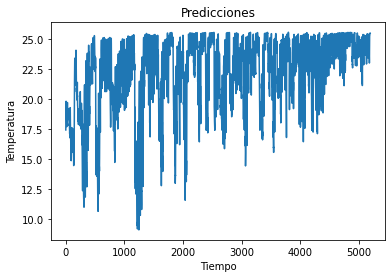

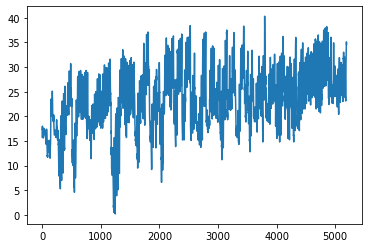

In [10]:
from matplotlib import pyplot as plt
plt.title("Predicciones") 
plt.xlabel("Tiempo") 
plt.ylabel("Temperatura") 
plt.plot(y_pred)
plt.show() 
plt.plot(y_test)